### 마약 센서 데이터 분류 모델(비공개 데이터)

In [112]:
# imports
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import gpflow as gp
#import gpsig
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import joblib
from cusum import multiCUSUM

sys.path.append('..')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
tf.logging.set_verbosity(tf.logging.ERROR)

In [113]:
class GPSigTrainer:
    def __init__(self, len_ex: int, n_feat: int, num_levels: int = 4, num_inducing: int = 200):
        self.len_ex = len_ex
        self.n_feat = n_feat
        self.num_levels = num_levels
        self.num_inducing = num_inducing
    


In [114]:
class Preprocessor:
    @staticmethod
    def load_data(directory_path: str) -> tuple:
        df_list = []
        df_names = []
        print(f"'{directory_path}' 디렉토리에서 CSV 파일을 탐색합니다.")

        if not os.path.isdir(directory_path):
            print(f"오류: '{directory_path}'는 유효한 디렉토리가 아닙니다.")
            return df_list

        for file_name in os.listdir(directory_path):
            if file_name.endswith('.csv'):
                full_path = os.path.join(directory_path, file_name)
                # 확장자를 제거하고 list에 추가
                file_name_without_ext = os.path.splitext(file_name)[0]
                df_names.append(file_name_without_ext)
                try:
                    df = pd.read_csv(full_path)
                    df_list.append(df)
                    print(f" - '{file_name}' 파일을 DataFrame으로 변환하여 리스트에 추가했습니다.")
                except Exception as e:
                    print(f" - 오류: '{file_name}' 파일을 읽는 중 문제가 발생했습니다: {e}")

        if not df_list:
            print("디렉토리에서 CSV 파일을 찾지 못했습니다.")
            
        return df_list, df_names

    @staticmethod
    def drop_col(df_list: list) -> list:
        """
        현재 drug 데이터에 맞추어져 있기 때문에
        하드코딩 되어있음.
        -> TVOC와 SHT 40 제거
        """
        for df in df_list:
            print(f"현재 데이터프레임의 컬럼: {df.columns.tolist()}")
            if 'TVOC' in df.columns:
                print("TVOC을 제거.")
                df.drop(labels=["Date", "Time", "TVOC"], axis=1, inplace=True)
            else:
                print("TVOC이 없습니다. SHT 40을 제거.")
                df.drop(labels=["Date", "Time", "SHT 40"], axis=1, inplace=True)
        for df in df_list:
            print(f"최종 데이터프레임의 컬럼: {df.columns.tolist()}")

        return df_list
    
    @staticmethod
    def detection_with_CUSUM(df_list: list, df_names: list, phase1: int = 150, threshold: float = 0.5, k: float = 2) -> list:
        phase1 = 150

        print(f"각 데이터의 처음 {phase1}개의 데이터를 정상 상태 기준으로 삼아 분석을 시작합니다.")
        print("-" * 60)

        result_CUSUM = []
        for df, name in zip(df_list, df_names):
            print(f"[{name} 데이터 분석 시작]")
            
            if len(df) <= phase1:
                print(f"  데이터 길이가 {phase1}보다 짧아 분석할 수 없습니다.")
                continue
            
            # 1. Phase I 데이터만으로 Scaler를 학습(fit)
            scaler = StandardScaler()
            phase1_df_for_scaling = df.iloc[:phase1]
            scaler.fit(phase1_df_for_scaling)

            # 2. 학습된 Scaler로 데이터프레임 전체를 변환(transform)
            df_scaled_values = scaler.transform(df)
            # 변환된 numpy 배열을 다시 DataFrame으로
            df_scaled = pd.DataFrame(df_scaled_values, columns=df.columns)

            # 3. 데이터 분리: 이제 표준화된(scaled) 데이터로 Phase I과 II를 나눕니다.
            phase1_data = df_scaled.iloc[:phase1].values
            phase2_data = df_scaled.iloc[phase1:].values
            
            # 4. CUSUM 객체 생성 및 학습 (이제 정상적인 threshold 사용)
            # 표준화된 데이터는 평균 0, 표준편차 1 근처의 값을 가지므로, 일반적인 threshold를 사용할 수 있습니다.
            # 보통 5~15 사이의 값으로 시작하여 튜닝합니다.
            cusum_chart = multiCUSUM(threshold=103.0, k=2.0)  # threshold를 1000이 아닌 10으로 변경
            cusum_chart.fit(phase1_data)
            
            # 5. 변화 시점 탐지 (이후 코드는 동일)
            detection_time = -1
            for t in range(len(phase2_data)):
                current_point = phase2_data[t, :]
                is_violation = cusum_chart.update(current_point)
                if is_violation:
                    detection_time = phase1 + t + 1
                    break
                    
            # 6. 결과 출력
            if detection_time != -1:
                print(f"==> 결과: '{name}'의 이상 탐지 시점은 【{detection_time}】 입니다.")
                result_CUSUM.append(detection_time)
            else:
                print(f"==> 결과: 분석 구간 내에서 '{name}'의 이상 변화가 탐지되지 않았습니다.")
                result_CUSUM.append(np.nan)
        return result_CUSUM

    @staticmethod
    def add_noise(df_list: list, noise_level: float = 0.05) -> list:
        dfs_noised = []
        print(f"노이즈 레벨: {noise_level}")
        for df in df_list:
            #print(f"현재 데이터의 타입: {type(df)}")
            
            numeric_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
            df_noised = df.copy()

            col_stds = df_noised[numeric_cols].std()
            #print(f"Numeric 컬럼: {numeric_cols}")
            #print(f"표준편차:\n{col_stds}")

            for col in numeric_cols:
                sd = col_stds[col]
                scale = sd * noise_level
                if scale == 0 or pd.isna(scale):
                    print(f"  - {col}: sd 0 또는 NaN → 노이즈 없음")
                    continue

                noise = np.random.normal(loc=0.0, scale=scale, size=df_noised.shape[0])
                df_noised[col] = df_noised[col] + noise
                print(f"  - {col}: sd={sd:.4g}, noise_scale={scale:.4g}")

            #print(f"Noise 적용후 head:\n{df_noised.head()}")
            dfs_noised.append(df_noised)

        return dfs_noised
    
    @staticmethod
    def generate_instances(df_list: list, repetitions: int = 10, noise_level: float = 0.03) -> pd.DataFrame:
        all_data = pd.DataFrame()
        
        for _ in range(repetitions):
            noised_list = Preprocessor.add_noise(df_list, noise_level=noise_level)
            # 각 반복마다 리스트를 받아서 concat 전용 DataFrame으로 변환
            concatenated = pd.concat(noised_list, axis=0, ignore_index=True)
            all_data = pd.concat([all_data, concatenated], axis=0, ignore_index=True)
            
        return all_data
    
    @staticmethod
    def reduce_row_by_mean(df: pd.DataFrame, divider: int = 10) -> pd.DataFrame:
        df = df.groupby(df.index // divider).mean().reset_index(drop=True)
        return df

In [115]:
dfs, df_names = Preprocessor.load_data('./data_drug')
dfs = Preprocessor.drop_col(dfs)

'./data_drug' 디렉토리에서 CSV 파일을 탐색합니다.
 - 'Amphetamine.csv' 파일을 DataFrame으로 변환하여 리스트에 추가했습니다.
 - 'Codein.csv' 파일을 DataFrame으로 변환하여 리스트에 추가했습니다.
 - 'Methanol.csv' 파일을 DataFrame으로 변환하여 리스트에 추가했습니다.
 - 'Morphine.csv' 파일을 DataFrame으로 변환하여 리스트에 추가했습니다.
 - 'Pentazocine.csv' 파일을 DataFrame으로 변환하여 리스트에 추가했습니다.
현재 데이터프레임의 컬럼: ['Date', 'Time', 'TGS800', 'TGS813', 'TGS822', 'TGS824', 'TVOC']
TVOC을 제거.
현재 데이터프레임의 컬럼: ['Date', 'Time', 'TGS800', 'TGS813', 'TGS822', 'TGS824', 'SHT 40']
TVOC이 없습니다. SHT 40을 제거.
현재 데이터프레임의 컬럼: ['Date', 'Time', 'TGS800', 'TGS813', 'TGS822', 'TGS824', 'TVOC']
TVOC을 제거.
현재 데이터프레임의 컬럼: ['Date', 'Time', 'TGS800', 'TGS813', 'TGS822', 'TGS824', 'TVOC']
TVOC을 제거.
현재 데이터프레임의 컬럼: ['Date', 'Time', 'TGS800', 'TGS813', 'TGS822', 'TGS824', 'TVOC']
TVOC을 제거.
최종 데이터프레임의 컬럼: ['TGS800', 'TGS813', 'TGS822', 'TGS824']
최종 데이터프레임의 컬럼: ['TGS800', 'TGS813', 'TGS822', 'TGS824']
최종 데이터프레임의 컬럼: ['TGS800', 'TGS813', 'TGS822', 'TGS824']
최종 데이터프레임의 컬럼: ['TGS800', 'TGS813', 'TGS822', 'TGS824']
최종 데이터프레임의

각 데이터의 처음 150개의 데이터를 정상 상태 기준으로 삼아 분석을 시작합니다.
------------------------------------------------------------
[Amphetamine 데이터 분석 시작]
==> 결과: 'Amphetamine'의 이상 탐지 시점은 【1951】 입니다.
[Codein 데이터 분석 시작]
==> 결과: 'Codein'의 이상 탐지 시점은 【1108】 입니다.
[Methanol 데이터 분석 시작]
==> 결과: 'Methanol'의 이상 탐지 시점은 【729】 입니다.
[Morphine 데이터 분석 시작]
==> 결과: 'Morphine'의 이상 탐지 시점은 【200】 입니다.
[Pentazocine 데이터 분석 시작]
==> 결과: 'Pentazocine'의 이상 탐지 시점은 【1134】 입니다.


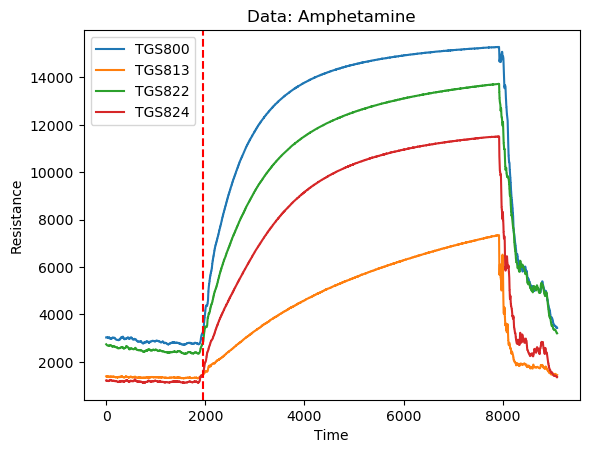

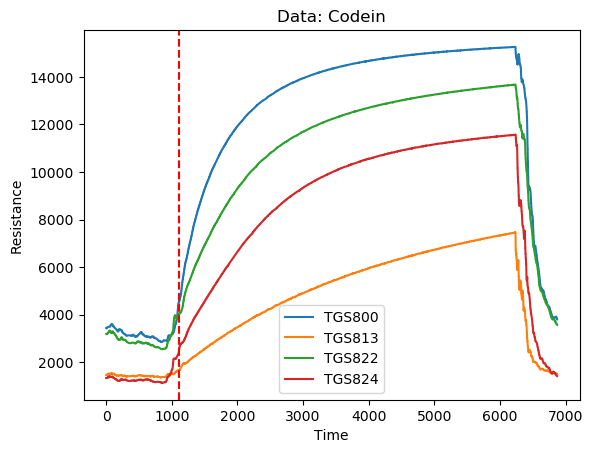

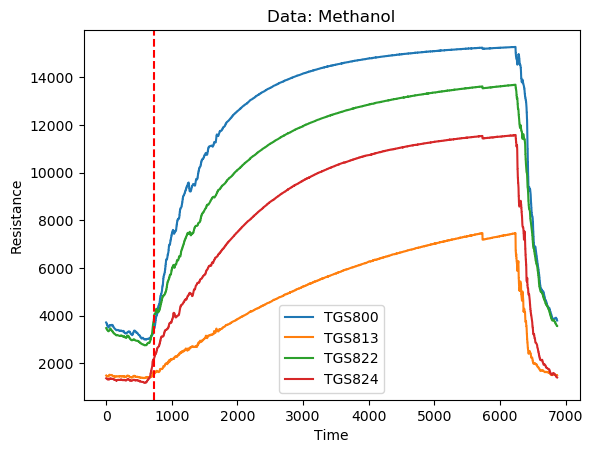

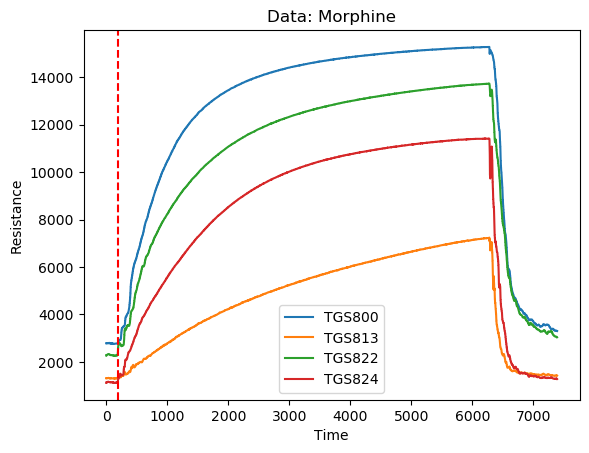

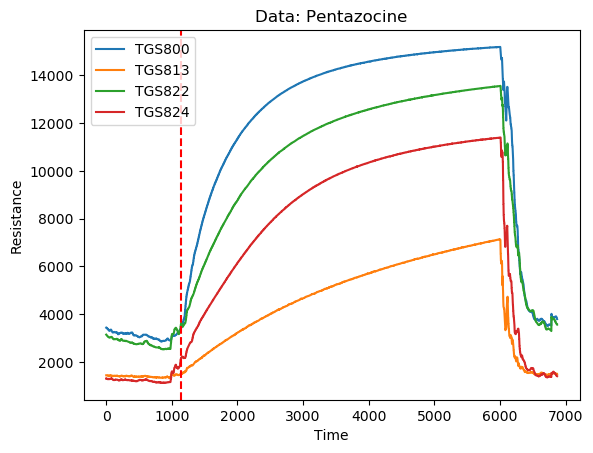

'\nCodein과 Methanol의 경우\n분산이 과대 추정되어 detection_time이 커지는 현상이 발생함\n'

In [116]:
detection_time = Preprocessor.detection_with_CUSUM(dfs, df_names, phase1=150, threshold=103.0, k=2.0)

for i in range(len(dfs)):
    plt.plot(dfs[i])
    plt.legend(dfs[i].columns)
    plt.title(f"Data: {df_names[i]}")
    plt.xlabel("Time")
    plt.ylabel("Resistance")
    plt.axvline(x=detection_time[i], color='r', linestyle='--')
    plt.show()

'''
Codein과 Methanol의 경우
분산이 과대 추정되어 detection_time이 커지는 현상이 발생함
'''

In [117]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].iloc[detection_time[i]:,:].reset_index(drop=True)

In [118]:
"""
for element in list: 반복문 변수에 재할당하면 원본 리스트 요소는 변경 안 됨
따라서 for i in range(len(dfs))로 변경
"""

for i in range(len(dfs)):
    dfs[i] = Preprocessor.reduce_row_by_mean(dfs[i], divider=10)
print(dfs[0].shape)
print(dfs[1].shape)

(715, 4)
(577, 4)


In [119]:
df_train = Preprocessor.generate_instances(dfs, repetitions=2, noise_level=0.03)

노이즈 레벨: 0.03
  - TGS800: sd=3610, noise_scale=108.3
  - TGS813: sd=1894, noise_scale=56.83
  - TGS822: sd=3183, noise_scale=95.5
  - TGS824: sd=3259, noise_scale=97.77
  - TGS800: sd=3070, noise_scale=92.1
  - TGS813: sd=1796, noise_scale=53.87
  - TGS822: sd=2818, noise_scale=84.54
  - TGS824: sd=2962, noise_scale=88.87
  - TGS800: sd=3214, noise_scale=96.42
  - TGS813: sd=1888, noise_scale=56.65
  - TGS822: sd=2859, noise_scale=85.78
  - TGS824: sd=2998, noise_scale=89.94
  - TGS800: sd=3967, noise_scale=119
  - TGS813: sd=1939, noise_scale=58.16
  - TGS822: sd=3491, noise_scale=104.7
  - TGS824: sd=3465, noise_scale=103.9
  - TGS800: sd=3698, noise_scale=110.9
  - TGS813: sd=1828, noise_scale=54.84
  - TGS822: sd=3246, noise_scale=97.38
  - TGS824: sd=3286, noise_scale=98.58
노이즈 레벨: 0.03
  - TGS800: sd=3610, noise_scale=108.3
  - TGS813: sd=1894, noise_scale=56.83
  - TGS822: sd=3183, noise_scale=95.5
  - TGS824: sd=3259, noise_scale=97.77
  - TGS800: sd=3070, noise_scale=92.1
  - T

### 아래부터 수정해야 함(250808)

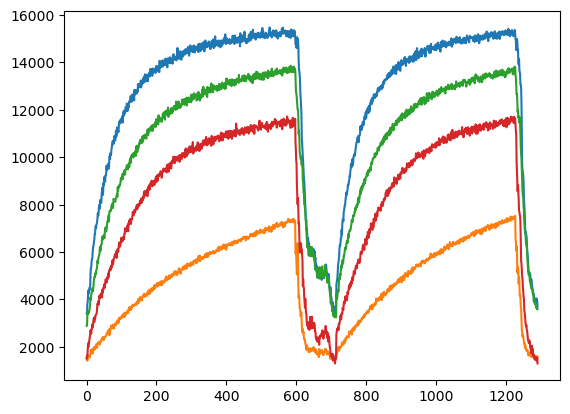

In [121]:
plt.plot(df_train.iloc[:1292,:])

In [83]:
df_train[0]

KeyError: 0

In [13]:
dfs_preprocess = []
length = []
NUM_REPETITIONS = 30
NOISE_LEVEL = 0.05
divider = 10

for df in dfs:
    df = df.groupby(df.index // divider).mean().reset_index(drop=True)
    #plt.plot(df)
    #plt.show()
    length.append(df.shape[0])
    print(f"df의 shape: {df.shape}")
    print(f"해당 df row({df.shape[0]}) * 반복 수({NUM_REPETITIONS}) = {df.shape[0]*NUM_REPETITIONS}")
    dfs_preprocess.append(generate_instances(df, repetitions=NUM_REPETITIONS, noise_=NOISE_LEVEL))

for _ in dfs_preprocess:
    print(_.shape)

df_train = pd.concat(dfs_preprocess, axis=0)

df의 shape: (615, 4)
해당 df row(615) * 반복 수(30) = 18450
df의 shape: (719, 4)
해당 df row(719) * 반복 수(30) = 21570
df의 shape: (715, 4)
해당 df row(715) * 반복 수(30) = 21450
df의 shape: (577, 4)
해당 df row(577) * 반복 수(30) = 17310
df의 shape: (574, 4)
해당 df row(574) * 반복 수(30) = 17220
(18450, 4)
(21570, 4)
(21450, 4)
(17310, 4)
(17220, 4)


In [14]:
dfs_preprocess = []
for df in dfs:
    df = df.groupby(df.index // divider).mean().reset_index(drop=True)
    dfs_preprocess.append(generate_instances(df, repetitions=NUM_REPETITIONS, noise_=NOISE_LEVEL))

df_test = pd.concat(dfs_preprocess, axis=0)

In [15]:
print(df_test.shape)

(96000, 4)


In [16]:
"""
class의 개수는 5개이고 각 class는 길이가 다르다.
feature는 현재 4개
"""
print(length)

[615, 719, 715, 577, 574]


In [17]:
X_train = pd.DataFrame(columns=['dim_0', 'dim_1', 'dim_2', 'dim_3'])

current_pos = 0  # 현재 처리 중인 데이터의 시작 인덱스를 추적
for _ in length: # _ 에는 각 클래스의 시계열 길이가 들어옵니다. (예: 620, 719, ...)
    for j in range(NUM_REPETITIONS):
        # [수정된 부분] 인덱스 계산
        start_idx = current_pos
        end_idx = current_pos + _
        #print(start_idx, end_idx)
    
        # 이하는 기존 코드와 동일합니다.
        dim_0_series = pd.Series(df_train.iloc[start_idx:end_idx, 0].values)
        dim_1_series = pd.Series(df_train.iloc[start_idx:end_idx, 1].values)
        dim_2_series = pd.Series(df_train.iloc[start_idx:end_idx, 2].values)
        dim_3_series = pd.Series(df_train.iloc[start_idx:end_idx, 3].values)
        X_train = X_train.append({
            'dim_0': dim_0_series,
            'dim_1': dim_1_series,
            'dim_2': dim_2_series,
            'dim_3': dim_3_series
        }, ignore_index=True)

        # [수정된 부분] 다음 시계열의 시작 위치로 업데이트
        current_pos = end_idx

In [18]:
for i in range(len(dfs)):
    print(list(dfs[i].iloc[0,:]))

[3441, 1582, 3906, 2198]
[2838, 1442, 2732, 1297]
[3264, 1449, 2795, 1466]
[4531, 1636, 3978, 2456]
[3382, 1502, 3460, 2069]


In [19]:
# 데이터가 제대로 입력되었는지 확인
X_train.iloc[[0, NUM_REPETITIONS-1,NUM_REPETITIONS,2*NUM_REPETITIONS-1,2*NUM_REPETITIONS],:]


,dim_0,dim_1,dim_2,dim_3
0,0 3634.985084 1 3725.107365 2 3...,0 1617.891647 1 1718.216019 2 1...,0 3719.571172 1 4021.873569 2 4...,0 2480.001968 1 2201.490770 2 2...
29,0 3575.570732 1 3602.371453 2 3...,0 1634.491874 1 1562.948338 2 1...,0 3965.085894 1 4040.218518 2 4...,0 2163.264736 1 2587.169240 2 2...
30,0 3144.409772 1 2939.590607 2 3...,0 1486.330484 1 1332.229437 2 1...,0 2588.630553 1 3109.706547 2 2...,0 1205.276801 1 1433.866760 2 1...
59,0 2991.888895 1 2826.766172 2 3...,0 1508.107908 1 1213.649546 2 1...,0 2828.732914 1 2983.092970 2 2...,0 1507.357057 1 1333.508050 2 1...
60,0 3568.757566 1 3442.434228 2 3...,0 1496.321097 1 1437.701332 2 1...,0 2803.390687 1 2777.713511 2 3...,0 1551.712422 1 1641.122117 2 1...


In [20]:
X_test = pd.DataFrame(columns=['dim_0', 'dim_1', 'dim_2', 'dim_3'])

current_pos = 0  # 현재 처리 중인 데이터의 시작 인덱스를 추적
for _ in length: # _ 에는 각 클래스의 시계열 길이가 들어옵니다. (예: 620, 719, ...)
    for j in range(NUM_REPETITIONS):
        # [수정된 부분] 인덱스 계산
        start_idx = current_pos
        end_idx = current_pos + _
    
        # 이하는 기존 코드와 동일합니다.
        dim_0_series = pd.Series(df_test.iloc[start_idx:end_idx, 0].values)
        dim_1_series = pd.Series(df_test.iloc[start_idx:end_idx, 1].values)
        dim_2_series = pd.Series(df_test.iloc[start_idx:end_idx, 2].values)
        dim_3_series = pd.Series(df_test.iloc[start_idx:end_idx, 3].values)
        X_test = X_test.append({
            'dim_0': dim_0_series,
            'dim_1': dim_1_series,
            'dim_2': dim_2_series,
            'dim_3': dim_3_series
        }, ignore_index=True)

        # [수정된 부분] 다음 시계열의 시작 위치로 업데이트
        current_pos = end_idx

In [21]:
X_test.iloc[[29,30,59,60],:]

,dim_0,dim_1,dim_2,dim_3
29,0 3429.943979 1 3571.882364 2 3...,0 1678.042496 1 1597.147385 2 1...,0 3941.255146 1 3919.115506 2 4...,0 2239.689280 1 1951.949901 2 2...
30,0 2702.737051 1 2892.299272 2 3...,0 1350.809221 1 1545.072456 2 1...,0 2883.409358 1 2514.477246 2 2...,0 1537.918893 1 1341.011101 2 1...
59,0 3195.068046 1 2466.328627 2 3...,0 1321.732377 1 1521.489309 2 1...,0 2511.406228 1 2681.808836 2 3...,0 1135.001769 1 1339.060237 2 1...
60,0 3621.298821 1 3444.575398 2 3...,0 1441.026536 1 1488.403336 2 1...,0 2927.986041 1 2769.761044 2 3...,0 1400.934155 1 1916.078210 2 1...


In [22]:
#%%
y_train = np.array([i for i in range(1, 6) for _ in range(NUM_REPETITIONS)])
y_test = y_train
y_test
#%%
labels_dict = {c : i for i, c in enumerate(np.unique(y_train))}
y_train = np.asarray([labels_dict[c] for c in y_train])
y_test = np.asarray([labels_dict[c] for c in y_test])


#
X_train = [np.stack(x, axis=1) for x in X_train.values]
X_test = [np.stack(x, axis=1) for x in X_test.values]

X_train = gpsig.preprocessing.add_time_to_list(X_train)
X_test = gpsig.preprocessing.add_time_to_list(X_test)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train)

scaler = StandardScaler().fit(np.concatenate(X_train, axis=0))

joblib.dump(scaler, "./std_scaler.pkl")

X_train = [scaler.transform(x) for x in X_train]
X_val = [scaler.transform(x) for x in X_val]
X_test = [scaler.transform(x) for x in X_test]


X_train = gpsig.preprocessing.tabulate_list_of_sequences(X_train)
X_val = gpsig.preprocessing.tabulate_list_of_sequences(X_val)
X_test = gpsig.preprocessing.tabulate_list_of_sequences(X_test)

num_train, len_examples, num_features = X_train.shape
print(X_train.shape)
num_val = X_val.shape[0]
num_test = X_test.shape[0]
num_classes = np.unique(y_train).size

num_levels = 4
num_inducing = 200
num_lags = 0

Z_init = gpsig.utils.suggest_initial_inducing_tensors(X_train, num_levels, num_inducing, labels=y_train, increments=True, num_lags=num_lags)
l_init = gpsig.utils.suggest_initial_lengthscales(X_train, num_samples=1000)

input_dim = len_examples * num_features
X_train = X_train.reshape([-1, input_dim])
X_val = X_val.reshape([-1, input_dim]) if X_val is not None else None
X_test = X_test.reshape([-1, input_dim])


feat = gpsig.inducing_variables.InducingTensors(
    Z_init,
    num_levels=num_levels,
    increments=True,
    name="MyInducingTensors")


k = gpsig.kernels.SignatureRBF(
    input_dim,
    num_features,
    num_levels,
    lengthscales=l_init,
    name="MySignatureRBF"
)

if num_classes == 2:
    lik = gp.likelihoods.Bernoulli(name="Bernoulli")
    num_latent = 1
else:
    lik = gp.likelihoods.MultiClass(num_classes, name="MultiClass")
    num_latent = num_classes

m = gpsig.models.SVGP(
    X_train, y_train[:, None],
    kern=k, feat=feat, likelihood=lik,
    num_latent=num_latent,
    minibatch_size=50,
    name="MySVGP"
)
    
acc = lambda m, X, y: accuracy_score(y, np.argmax(m.predict_y(X)[0], axis=1))
nlpp = lambda m, X, y: -np.mean(m.predict_density(X, y[:, None]))

val_acc = lambda m: acc(m, X_val, y_val)
val_nlpp = lambda m: nlpp(m, X_val, y_val)

test_acc = lambda m: acc(m, X_test, y_test)
test_nlpp = lambda m: nlpp(m, X_test, y_test)

opt = gpsig.training.NadamOptimizer

print(1)

100%|██████████| 150/150 [00:00<?, ?it/s]


(120, 719, 5)
1


In [ ]:

m.kern.set_trainable(False)
hist = gpsig.training.optimize(m, opt(1e-3), max_iter=1800, print_freq=10, save_freq=100, val_scorer=[val_acc, val_nlpp])

m.kern.set_trainable(True)
hist = gpsig.training.optimize(m, opt(1e-2), max_iter=2000, print_freq=10, save_freq=100, history=hist,
                               val_scorer=[val_acc, val_nlpp], save_best_params=True, lower_is_better=True, patience=5000)
m.assign(hist['best']['params'])

X_train, y_train = np.concatenate((X_train, X_val), axis=0), np.concatenate((y_train, y_val), axis=0)
num_train = X_train.shape[0]
m.X, m.Y = X_train, y_train
m.num_data = num_train

m.kern.set_trainable(False)
hist = gpsig.training.optimize(m, opt(1e-3), max_iter=1000, print_freq=10, save_freq=100, history=hist)

-------------------------
  Starting optimization  
-------------------------
Iteration 10	|	Time: 45.56

KeyboardInterrupt: 

In [ ]:
print('Test nlpp.: {:.03f}'.format(test_nlpp(m)))
print('Test acc.: {:.03f}'.format(test_acc(m)))
print('Test classification report:')
print(classification_report(y_test, np.argmax(m.predict_y(X_test)[0], axis=1)))

In [ ]:
print(m.as_pandas_table())

In [ ]:
time = [y['time'] for x, y in hist.items() if str(x).isnumeric()]
elbo = [y['elbo'] for x, y in hist.items() if str(x).isnumeric()]
val_acc = [y['val'][0] for x, y in hist.items() if str(x).isnumeric() and 'val' in y]
val_nlpp = [y['val'][1] for x, y in hist.items() if str(x).isnumeric() and 'val' in y]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(time, elbo)
axes[0].set_title('ELBO over time')
axes[1].plot(time[:len(val_nlpp)], val_acc, 'tab:orange')
axes[1].set_title('Validation acc. over time')
axes[2].plot(time[:len(val_nlpp)], val_nlpp, 'tab:red')
axes[2].set_title('Validation nlpp. over time')

plt.show()

NameError: name 'plt' is not defined

In [ ]:
os.makedirs("./ckpt_tf", exist_ok=True)

with m.enquire_session() as sess:
    tf_saver = tf.train.Saver()
    tf_saver.save(sess, "./ckpt_tf/svgp_tf")
    print("TF-Saver checkpoint saved")

RuntimeError: Attempted to use a closed Session.